In [1]:
from vqls import *
from utils import *


T dim 10
x_dim 9


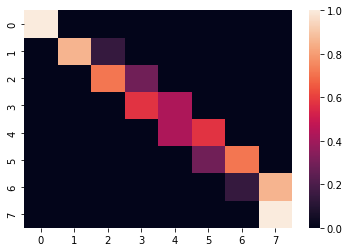

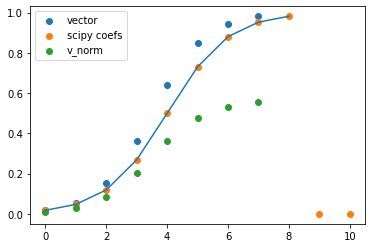

Condition number
 62.475138845718426
norm(yk) 1.77256959808715


In [2]:
lower = 0.
upper = 1. 
n_step = 8
f_i = 0.0  
MAX_ITER = 100

nq=3
# K = 2^n = dim(T)-2
# with dim(S) = KxK
# n = num qubits
# T = set of knots

scaled=False

label = 'sigmoid'
func = sigmoid_t


x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
  norm = np.linalg.norm(y)
  y = y / norm
tck=splrep(x,y,k=1) #coeffs
#plt.scatter(range(len(tck[1])),tck[0], label = "scipy knots")


#############################################################################################
###################################### System Preparation ###################################
#############################################################################################

matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled);

import seaborn as sns

sns.heatmap(matrix)
plt.show()
plt.plot(y)

plt.scatter(range(len(vector)), vector, label="vector")
plt.scatter(range(len(tck[1])),tck[1], label="scipy coefs")
plt.scatter(range(len(v_norm)), v_norm, label="v_norm")
plt.legend()
plt.show()
#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################

k_numb=np.linalg.cond(np.array(matrix))
print('Condition number\n',k_numb)
print('norm(yk)',np.linalg.norm(vector))




## asbgn


In [3]:
vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 
q = vqls_circuit

In [4]:
import time
weights = np.load("weights_8.npy")

Optimizing variational params..
Starting parameters = {w}
Cost at Step 0: 0.0148778
Cost at Step 1: 0.0919554
Cost at Step 2: 0.1044500
Cost at Step 3: 0.0720573
Cost at Step 4: 0.1126275
Cost at Step 5: 0.1272639
Cost at Step 6: 0.1031091
Cost at Step 7: 0.0679785
Cost at Step 8: 0.0947326
Cost at Step 9: 0.0987770
Cost at Step 10: 0.1500628
Cost at Step 11: 0.0532584
Cost at Step 12: 0.0112093
Cost at Step 13: 0.0144253
Cost at Step 14: 0.0198370
Cost at Step 15: 0.0111752
Cost at Step 16: 0.0203092
Cost at Step 17: 0.0121095
Cost at Step 18: 0.0192403
Cost at Step 19: 0.0139235
Cost at Step 20: 0.0167938
Cost at Step 21: 0.0137052
Cost at Step 22: 0.0107022
Cost at Step 23: 0.0104997
Cost at Step 24: 0.0110780
Cost at Step 25: 0.0119244
Cost at Step 26: 0.0101392
Cost at Step 27: 0.0102269
Cost at Step 28: 0.0093744
Cost at Step 29: 0.0134859
Cost at Step 30: 0.0097368
Cost at Step 31: 0.0083956
Cost at Step 32: 0.0095259
Cost at Step 33: 0.0126434
Cost at Step 34: 0.0081032
Cost at

d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,


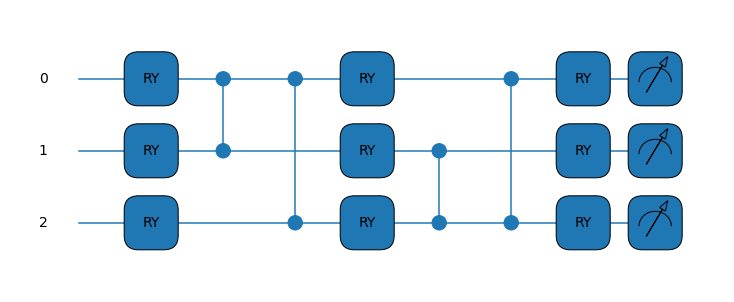

In [5]:
vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 

print('Optimizing variational params..')
start = time.time()
weights = vqls_circuit.train(max_iter=MAX_ITER, warm_start= weights)  
end = time.time()
print("The time of execution of above program is :", end-start)
q = vqls_circuit.solution(weights, True)
print('Quantum coefficients         :',q)
print("Variational Circuit's weights:",weights)


In [6]:
np.save(f"weights_{n_step}_{MAX_ITER}", weights)

7
(<Figure size 720x288 with 1 Axes>, <Axes:>)


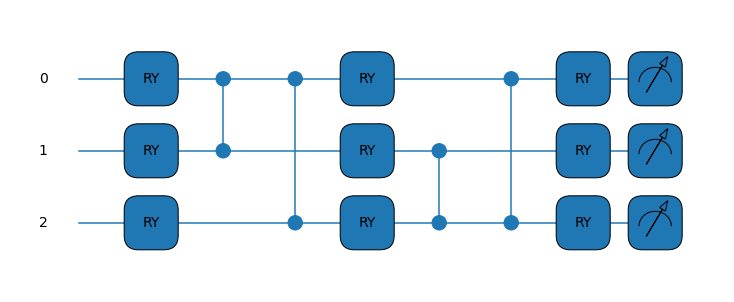

In [7]:
q = vqls_circuit.solution(weights, True, True)


## aosiegn


In [8]:
#Classic beta coefficients
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
y_c=np.dot(matrix,c) #classic


y_q=np.dot(matrix,q) #hybrid
                     #Quantum
y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))
  
rss_full = np.sum(np.square(np.array(y_c) - np.array(y_fq)))
rss_hybr = np.sum(np.square(np.array(y_c) - np.array(y_q)))

print('RSS_q:',rss_full)
print('RSS_h:',rss_hybr)



beta_classic                 : [ 0.01798621  0.07173906 -0.0502415   0.65973407 -0.0375285   1.14655868
  0.7277244   0.98201379]
RSS_q: 0.27266335752248877
RSS_h: (0.47208944189058544+0j)


In [9]:
len(y_fq)

8

d:\conda\envs\res\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


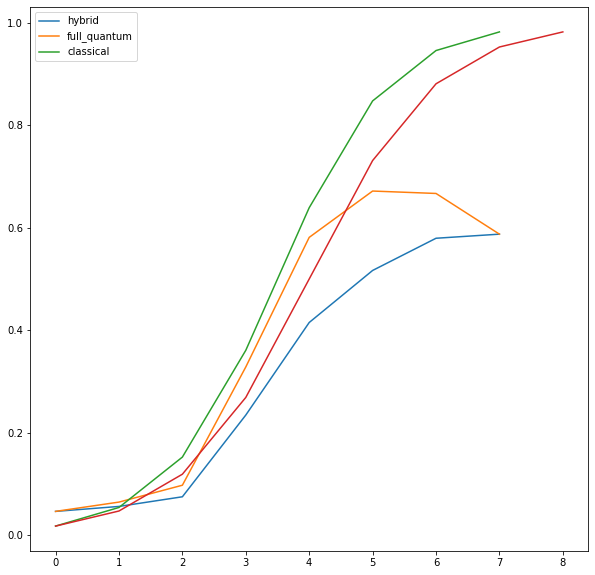

In [10]:
plt.figure(figsize=(10,10))
plt.plot(range(len(y_fq)),y_q,label= "hybrid")
plt.plot(range(len(y_fq)),y_fq, label="full_quantum")
plt.plot(range(len(y_fq)),y_c, label="classical")
plt.plot(y)
plt.legend()

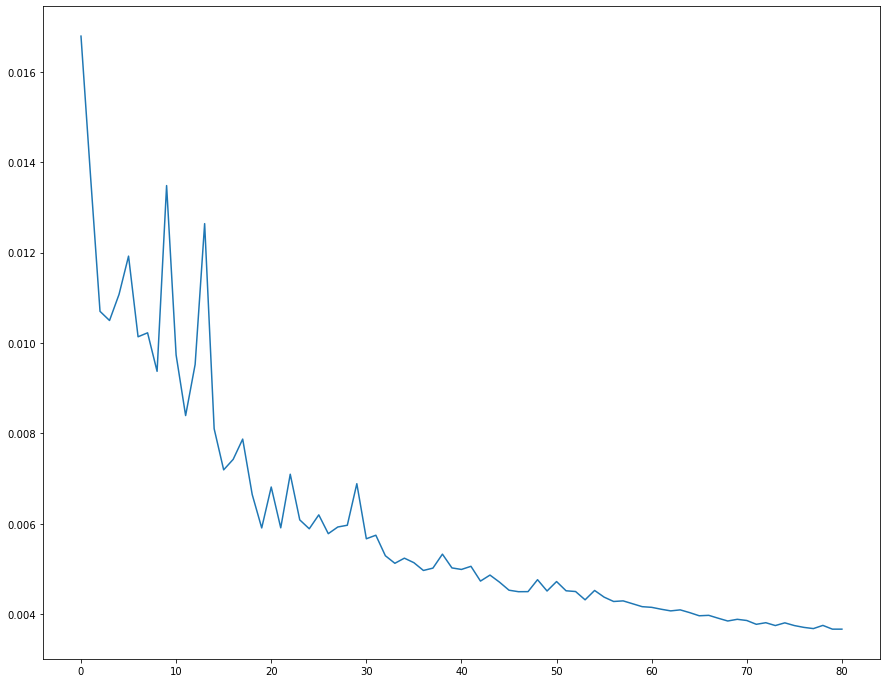

In [21]:
plt.figure(figsize=(15,12))
plt.plot(vqls_circuit.cost_vals[20:]);